Found 99 files belonging to 2 classes.
Using 80 files for training.
Using 19 files for validation.


2024-06-05 15:14:32.105047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


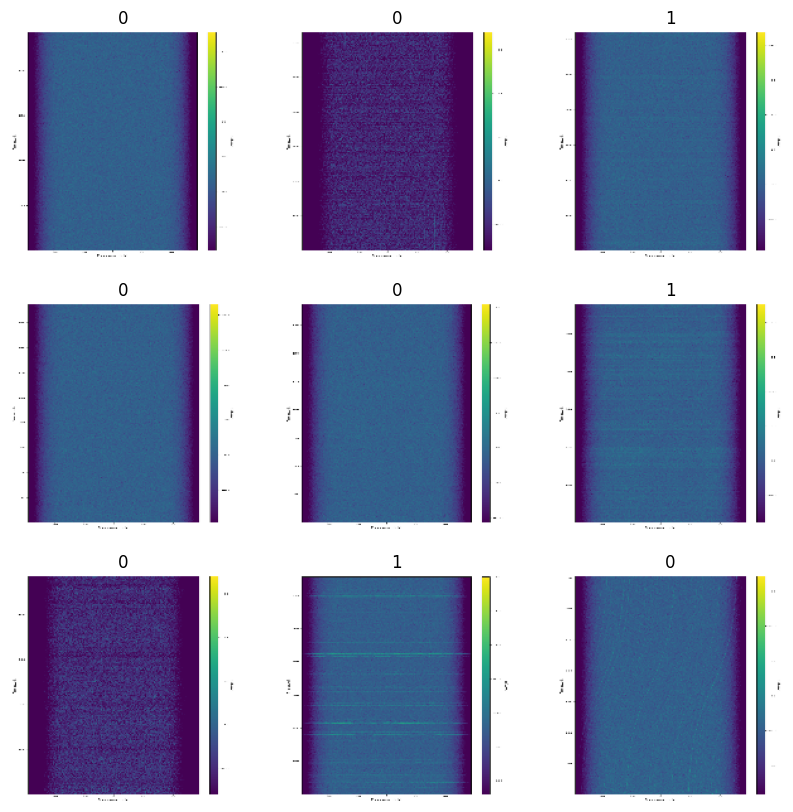

In [14]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

# Set paths for the dataset
data_dir = 'data/98899/Mode U - Transmitter/waterfall'
# good_signals_dir = os.path.join(data_dir, 'good')
# bad_signals_dir = os.path.join(data_dir, 'bad')

image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")



In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - acc: 0.4750 - loss: 0.7040 - val_acc: 0.4211 - val_loss: 0.6933
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - acc: 0.5125 - loss: 0.7039 - val_acc: 0.4211 - val_loss: 0.6935
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - acc: 0.5375 - loss: 0.6530 - val_acc: 0.4211 - val_loss: 0.6934
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - acc: 0.5625 - loss: 0.6507 - val_acc: 0.4211 - val_loss: 0.6933
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - acc: 0.6500 - loss: 0.6367 - val_acc: 0.4211 - val_loss: 0.6934
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - acc: 0.6750 - loss: 0.6277 - val_acc: 0.4211 - val_loss: 0.6936
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - acc: 0.6125 - loss: 0.5924 - val_acc: 0.4211 - val_loss: 0.6938
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - acc: 0.6125 - loss: 0.5623 - val_acc: 0.4211 - val_loss: 0.6939
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - acc: 0.6500 - loss: 0.5820 - 

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")